In [98]:
import numpy as np
from numpy.random import randint
from numpy.random import rand
import matplotlib.pyplot as plt
import math

In [99]:
# The objective function
def objective(x):
    f = (x[1]-x[0])**4  + 12*x[0]*x[1] - x[0] + x[1] - 3
    return f

In [100]:
# The decode function decodes binary bitstrings to numbers for each input and scales the value to fall within defined bounds
def decode(bounds, n_bits, bitstring):
    """
    This function decodes binary bitstrings to numbers for each input and scales the value to fall within defined bounds.
    
    Parameters:
    bounds (list): A list of tuples representing the lower and upper bounds for each value to be decoded.
    n_bits (int): The number of bits used to represent each value.
    bitstring (list): A binary bitstring to be decoded.
    
    Returns:
    decoded (list): A list of decoded values.
    """
    decoded = []  # Create an empty list to hold the decoded values
    largest = 2**n_bits  # The largest value that can be represented with the given number of bits
    for i in range(len(bounds)):
        # Extract the substring for the current value
        start, end = i * n_bits, (i * n_bits) + n_bits  # Define the start and end indicies of the substrings
        substring = bitstring[start:end] # Extract the substring
        # Convert the substring to a string of characters
        chars = ''.join([str(s) for s in substring])  # Join the values of the substring together into a string of characters
        # Convert the string of characters into an integer
        integer = int(chars, 2) # Convert the binary number string into an integer, base=2
        # Scale the integer to the desired range
        value = bounds[i][0] + (integer/largest) * (bounds[i][1]-bounds[i][0]) # Scale the integer to a value within the defined bounds
        # Store the decoded value
        decoded.append(value)
    return decoded

In [101]:
def selection(pop, scores, k=3):
    """
    Select the best individuals for the next generation based on their fitness (scores).
    This function randomly selects k individuals from the population and performs a tournament
    among them to choose the one with the best score.
    
    Parameters:
    pop (list): The population of individuals.
    scores (list): The fitness scores for each individual in the population.
    k (int, optional): The number of individuals to select from the population for the tournament.
                        Defaults to 3.
    
    Returns:
    individual: The best individual from the tournament.
    """
    # Randomly select one index from the population as the initial selection
    selection_ix = randint(len(pop))
    # Perform a tournament among k randomly selected individuals
    for ix in randint(0, len(pop), k-1):
        # Check if current individual has a better score then the selected one
        if scores[ix] < scores[selection_ix]:
            # Update the selected individual if a better one is found
            selection_ix = ix
    # Return the best individual from the tournament
    return pop[selection_ix]

In [102]:
def crossover(p1, p2, r_cross):
    """
    Create two children from two parents using the crossover operation.
    The children are created by copying the parents, and recombination occurs
    if a random value is less than the crossover rate.

    Parameters:
    p1 (list): The first parent.
    p2 (list): The second parent.
    r_cross (float): The crossover rate.

    Returns:
    list: A list containing the two children.
    """
    # Children are copies of the parents by default
    c1, c2 = p1.copy(), p2.copy()
    # Check if recombination should occur
    if rand() < r_cross:
        # Select a crossover point (not at the ends of the string)
        pt = randint(1,len(p1)-2) # from the 2nd index to the 2nd-to-last index
        # Perform crossover in children
        c1 = p1[:pt] + p2[pt:]
        c2 = p2[:pt] + p1[pt:]
    # Return the two children
    return [c1, c2]

In [103]:
# The crossover process can generate offsprings that are very similar to the parents. This might cause a new generation with low diversity.
# The mutation process solves this problem by changining the value of some features in the offspring at random.

def mutation(bitstring, r_mut):
    """
    The mutation process changes the value of some features in the offspring at random to maintain the diversity in the population.
    A standard value for the mutation rate is 1/m where m is the number of features.

    Parameters:
    bitstring (list): A list of binary values representing the offspring
    r_mut (float): The mutation rate, typically 1/m where m is the number of features

    Returns:
    list: The modified bitstring after mutation

    """
    for i in range(len(bitstring)):
        # Check for mutation
        if rand() < r_mut:
            # Flip the bit
            bitstring[i] = 1 - bitstring[i]
    return bitstring

In [106]:
### Putting all together into our Genetic algorithm that runs until it finds the best
# The whole fitness assignment, selection, recombination, and mutation process is repeated until a stopping criterion is satisfied.
# Each generation is likely to be more adapted to the environment than the old one.

# genetic algorithm implementation
def genetic_algorithm(objective, bounds, n_bits, n_iter, n_pop, r_cross, r_mut):
    """
    The genetic algorithm that finds the optimal solution by performing the fitness assignment, selection, recombination, and mutation process repeatedly.
    Each iteration, the solution is more adapted to the environment.

    Parameters
    ----------
    objective: function
        The objective function that needs to be optimized.
    bounds: list of tuples
        The bounds of the solution.
    n_bits: int
        The number of bits used to encode the solution.
    n_iter: int
        The number of iterations to perform.
    n_pop: int
        The size of the population.
    r_cross: float
        The crossover rate.
    r_mut: float
        The mutation rate.

    Returns
    -------
    list
        The best solution and its evaluation.
    """
    # Initialize the population with random bitstrings
    pop = [randint(0, 2, n_bits * len(bounds)).tolist() for _ in range(n_pop)]

    # Initialize storage containers for plot
    best_scores = list() # STORE
    avg_scores = list()
    worst_scores = list()

    # Initialize the tracking of the best solution found so far
    best, best_eval = 0, objective(decode(bounds, n_bits, pop[0]))

    # Iterate over generations
    for gen in range(n_iter):
        # decode the population
        decoded = [decode(bounds, n_bits, p) for p in pop]
        # evaluate all candidates in the population
        scores = [objective(d) for d in decoded]
        # update mean and worst solutions
        avg_eval = np.average(scores)
        worst_eval = max(scores)
        avg_scores.append(avg_eval), worst_scores.append(worst_eval)
        
        # check for new best solution
        for i in range(n_pop):
            if scores[i] < best_eval:
                best, best_eval = pop[i], scores[i]
                print(">%d, new best f(%s) = %f" % (gen, decoded[i], scores[i])) 
        best_scores.append(best_eval)
        
        # select parents
        selected = [selection(pop, scores) for _ in range(n_pop)]

        # create the next generation - children
        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents
            p1, p2 = selected[i], selected[i + 1]
            # crossover and mutation
            for child in crossover(p1, p2, r_cross):
                # mutation
                mutation(child, r_mut)
                # store for the next generation
                children.append(child)
        # replace the population
        pop = children
    return [best, best_eval, best_scores, avg_scores, worst_scores]

In [120]:
# define range for input
bounds = [[-3.0, 3.0], [-3.0, 3.0]]
# define the total iterations
n_iter = 50
# bits per variable
n_bits = 16
# define the population size
n_pop = 100
# crossover rate
r_cross = 0.75
# mutation rate
r_mut = 0.01
# perform the genetic algorithm search
best, score, best_scores, avg_scores, worst_scores = genetic_algorithm(objective, bounds, n_bits, n_iter, n_pop, r_cross, r_mut)
print('###########################################################')
decoded = decode(bounds, n_bits, best)
print('The result is (%s) with a score of %f' % (decoded, score))

>0, new best f([2.3843994140625, -1.5146484375]) = 180.880891
>0, new best f([1.569854736328125, -0.418853759765625]) = 2.762537
>0, new best f([0.720245361328125, 0.02764892578125]) = -3.223526
>0, new best f([0.64398193359375, -0.63006591796875]) = -6.508289
>7, new best f([0.665496826171875, -0.62969970703125]) = -6.509834
>8, new best f([0.665496826171875, -0.632720947265625]) = -6.510633
>11, new best f([0.652313232421875, -0.632720947265625]) = -6.510987
>12, new best f([0.658172607421875, -0.63262939453125]) = -6.511232
>13, new best f([0.658172607421875, -0.632720947265625]) = -6.511259
>13, new best f([0.659637451171875, -0.656158447265625]) = -6.512251
>14, new best f([0.652313232421875, -0.649566650390625]) = -6.513875
>15, new best f([0.652313232421875, -0.649658203125]) = -6.513875
>17, new best f([0.650848388671875, -0.649658203125]) = -6.513900
>22, new best f([0.650665283203125, -0.650299072265625]) = -6.513905
>24, new best f([0.650482177734375, -0.650299072265625]) = 

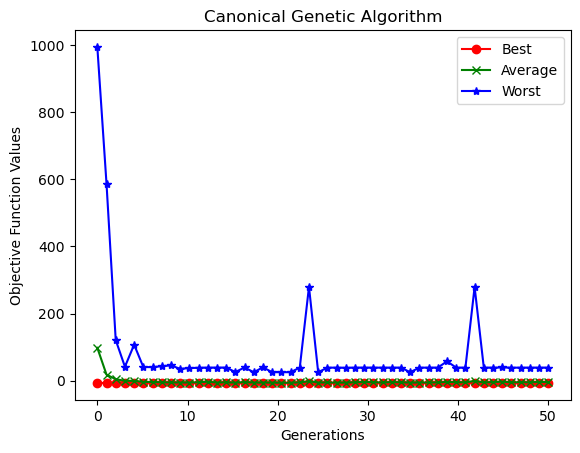

In [121]:
# Plotting each line
plt.plot(np.linspace(0,n_iter), best_scores, label='Best', marker='o', color='red')
plt.plot(np.linspace(0,n_iter), avg_scores, label='Average', marker='x', color='green')
plt.plot(np.linspace(0,n_iter), worst_scores, label='Worst', marker='*', color='blue')

# Adding labels and title
plt.xlabel('Generations')
plt.ylabel('Objective Function Values')
plt.title('Canonical Genetic Algorithm')

# Adding a legend to differentiate the lines
plt.legend()

# Show the plot
plt.show()